In [1]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None 
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

2024-08-10 05:57:50.954886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 05:57:50.996557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 05:57:51.673271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#df for 128 embeddings
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_128embeddings.pkl')

In [3]:
df

,mp3_path,tags,caption_writing,caption_embedding
clip_id,,,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...,"[0.008151676, 0.07329603, 0.99982566, 0.999194..."
6,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...,"[0.00060438353, 0.008377695, 0.9999999, 0.9999..."
10,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...,"[0.01728542, 0.09863398, 0.9972607, 0.99550676..."
11,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...,"[0.71541905, 0.26625627, 0.321584, 0.12895806,..."
14,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...,"[0.61524045, 0.066562384, 0.57550013, 0.125865..."
...,...,...,...,...
58896,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...,"[0.00046028176, 0.00919829, 1.0, 0.9999956, 0...."
58897,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...,"[0.5059766, 0.5534531, 0.11177488, 0.28386918,..."
58898,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...,"[0.025425518, 0.18722717, 0.9976993, 0.9913013..."


## Training the model

In [4]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [5]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

In [6]:
# data = []
# i = 0

# for filename in audio_names_list: #iterates over the filtered_df audio names
#     filename_npy = str(filename[:-4]) + '.npy'
#     file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
#     img = np.load(file_path)
#     data.append(add_gauss_noise(img))

#     # To ensure that the files are getting loaded in the correct order
#     if i < 10 :
#         print(filename)
#     i = i+1

# data = np.array(data)

In [7]:
data = np.load('/home/mendu/Thesis/data/magnatagatune/saved_df_data/data_array.npy')

In [8]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [9]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255)

In [10]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split into training (0.8) and remaining set (0.2)
X_train_spec, X_rem_spec, X_train_embed, X_rem_embed, y_train, y_rem = train_test_split(data, embeddings, pd.get_dummies(df['tags']), test_size=0.2, random_state=42)

# Split the remaining set into validation (0.1) and test (0.1)
X_val_spec, X_test_spec, X_val_embed, X_test_embed, y_val, y_test = train_test_split(X_rem_spec, X_rem_embed, y_rem, test_size=0.5, random_state=42)

In [11]:
# Now, convert this array of arrays into a proper 2D NumPy array
X_train_embed_array = np.stack(X_train_embed, axis=0)

# Check the new shape to ensure it's (450, 64)
print("Shape after conversion:", X_train_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_train_embed_tensor = tf.convert_to_tensor(X_train_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_train_embed_tensor.shape)

Shape after conversion: (9460, 128)
Tensor shape: (9460, 128)


2024-08-10 05:57:57.058840: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# Convert the 1D array of arrays into a proper 2D NumPy array
X_val_embed_array = np.stack(X_val_embed, axis=0)
X_test_embed_array = np.stack(X_test_embed, axis=0)

# Check the new shape to ensure it's in the correct format
print("Shape after conversion:", X_val_embed_array.shape)
print("Shape of test after conversion:", X_test_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_val_embed_tensor = tf.convert_to_tensor(X_val_embed_array, dtype=tf.float32)
X_test_embed_tensor = tf.convert_to_tensor(X_test_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_val_embed_tensor.shape)
print("Tensor shape of test:", X_test_embed_tensor.shape)

Shape after conversion: (1183, 128)
Shape of test after conversion: (1183, 128)
Tensor shape: (1183, 128)
Tensor shape of test: (1183, 128)


In [13]:
# Convert training data to tensors
X_train_spec = tf.convert_to_tensor(X_train_spec, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convert validation data to tensors
X_val_spec = tf.convert_to_tensor(X_val_spec, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

# Convert validation data to tensors
X_test_spec = tf.convert_to_tensor(X_test_spec, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [14]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train_spec)

In [15]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

8

In [16]:
def create_model(num_classes, l1_reg=0.01, l2_reg=0.1, alpha=0.0):
    class ModelSubClassing(keras.Model):
        def __init__(self, num_classes, l1_reg=0.01, l2_reg=0.1, alpha = 0):
            super().__init__()
            
            # Define L1 and L2 regularizer
            self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
            # self.l2_regularizer = regularizers.l2(l2_reg)
            
            # Define alpha the loss regulator
            self.alpha = alpha
            
            # number of classes
            self.num_classes = num_classes
            
            # Initialize layers as None
            self.conv1 = None
            self.max1 = None
            self.bn1 = None
            self.conv2 = None
            self.bn2 = None
            self.max2 = None
            self.drop1 = None
            self.conv3 = None
            self.bn3 = None
            self.max3 = None
            self.drop2 = None
            self.flatten = None
            self.dense128 = None
            self.dense128_relu = None
            self.dense128_sig = None
            self.dense128_do = None
            self.dense64 = None
            self.dense64_act = None
            self.dense_out = None
            
            self.loss_tracker = keras.metrics.Mean(name="loss")
            self.accuracy = keras.metrics.CategoricalAccuracy(name="accuracy")
            self.precision = Precision(name="precision")
            self.recall = Recall(name="recall")
            self.f1_score = keras.metrics.Mean(name="f1_score")

        def build(self, input_shape):
            # Create layers
            self.conv1 = Conv2D(32, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.max1  = MaxPooling2D(3)
            self.bn1   = BatchNormalization(momentum=0.9)

            self.conv2 = Conv2D(64, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.bn2   = BatchNormalization(momentum=0.9)
            self.max2  = MaxPooling2D(3)
            self.drop1 = Dropout(0.3)

            self.conv3 = Conv2D(128, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.bn3   = BatchNormalization(momentum=0.9)
            self.max3  = MaxPooling2D(3)
            self.drop2 = Dropout(0.3)

            self.flatten = Flatten()
            self.dense128 = Dense(128)
            self.dense128_act_relu = Activation('relu')
            self.dense128_act_sig = Activation('sigmoid')
            self.dense128_do = Dropout(0.3)
            self.dense64 = Dense(64)
            self.dense64_act = Activation('relu')
            self.dense_out = Dense(self.num_classes, activation="softmax")
            
            super().build(input_shape)

        def call(self, inputs, training=None):
            # Unpack the inputs
            mel_spectrogram = inputs[0]

            # Forward pass: block 1
            x = self.conv1(mel_spectrogram)
            x = self.max1(x)
            x = self.bn1(x, training=training)

            # Forward pass: block 2
            x = self.conv2(x)
            x = self.bn2(x, training=training)
            x = self.max2(x)
            x = self.drop1(x, training=training)

            # Forward pass: block 3
            x = self.conv3(x)
            x = self.bn3(x, training=training)
            x = self.max3(x)
            x = self.drop2(x, training=training)

            # Flatten and dense layers
            x = self.flatten(x)
            x_dense128 = self.dense128(x)
            x_dense128_act_sig = self.dense128_act_sig(x_dense128)
            x_dense128_act_relu = self.dense128_act_relu(x_dense128)
            x_dense128_act = self.dense128_do(x_dense128_act_relu, training=training)
            
            # dense layer 64
            x_dense64 = self.dense64(x_dense128_act)
            x_dense64_act_relu = self.dense64_act(x_dense64)
            y_hat = self.dense_out(x_dense64_act_relu)
            
            return y_hat, x_dense128_act_sig


        def train_step(self, data):
            # Unpack the data
            (mel_spectrogram, caption_embedding), y = data

            with tf.GradientTape() as tape: 
            #here we get the gradients of the trainable weights with this loss
                y_pred, x_dense = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
                # Compute the standard loss value
                loss = self.compiled_loss(y, y_pred)
                custom_loss = self.custom_loss(caption_embedding, x_dense)
                total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

            # Compute gradients
            gradients = tape.gradient(total_loss, self.trainable_variables)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            # Update the loss metric and any additional metrics
            self.loss_tracker.update_state(total_loss) 
            self.accuracy.update_state(y, y_pred)
            self.precision.update_state(y, y_pred)
            self.recall.update_state(y, y_pred)
            
            # Calculate F1 score
            f1 = 2 * ((self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
            self.f1_score.update_state(f1)

            return {
                "loss": self.loss_tracker.result(),
                "accuracy": self.accuracy.result(),
                "ce_loss": loss,
                "embedding_loss": custom_loss,
                "total loss": total_loss,
                "alpha": self.alpha,
                "precision": self.precision.result(),
                "recall": self.recall.result(),
                "f1_score": self.f1_score.result(),
            }
            
        def test_step(self, data):
            # Unpack the data
            (mel_spectrogram, caption_embedding), y = data

            
            y_pred, x_dense = self((mel_spectrogram, caption_embedding), training=False)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)
            custom_loss = self.custom_loss(caption_embedding, x_dense)
            total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

            # Update the loss metric and any additional metrics
            self.loss_tracker.update_state(total_loss)
            self.accuracy.update_state(y, y_pred)
            self.precision.update_state(y, y_pred)
            self.recall.update_state(y, y_pred)
            
            # Calculate F1 score
            f1 = 2 * ((self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
            self.f1_score.update_state(f1)
            
            return {
                "loss": self.loss_tracker.result(),
                "accuracy": self.accuracy.result(),
                "ce_loss": loss,
                "total loss": total_loss,
                "alpha": self.alpha,
                "precision": self.precision.result(),
                "recall": self.recall.result(),
                "f1_score": self.f1_score.result(), 
            }
            
        # Add a custom loss method in the model
        def custom_loss(self, caption_embedding, x_dense):
            # Compute the Mean Squared Error (MSE) between caption_embedding and x_dense64
            return tf.reduce_mean(tf.square(caption_embedding - x_dense))

        #new
        @property
        def metrics(self):
            # List all metrics to be reset after each epoch
            return [self.loss_tracker, self.accuracy]
        
        
    # Creating the class object

    model = ModelSubClassing(num_classes, l1_reg, l2_reg, alpha)

    # Compile the model
    adam_opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# Define hyperparameters for grid search
param_grid = {
    'alpha': [0, 0.25, 0.5, 0.75, 1]
    # 'l1_reg': [0.01, 0.001],
    # 'l2_reg': [0.1, 0.01, 0.001]
}

only_alpha = False

if ("alpha" in param_grid) & (len(param_grid) == 1):
    only_alpha = True

checkpoint_folder = f"/home/mendu/Thesis/data/saved_models/grid_search_alpha_128"

# Ensure the checkpoint folder exists
os.makedirs(checkpoint_folder, exist_ok=True)

# Define an empty dictionary to store history objects
history_dict = {}
results_dict = {}
models = {}

# Perform grid search
best_accuracy = 0
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    
    model = create_model(num_classes, **params)
    
    checkpoint_file = f"_{params['alpha']}.keras"
    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_file)
    
    # Initialize the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',  # Monitor validation accuracy
                                   save_best_only=True,     # Save only the best model
                                   verbose=0)
    
    rlronp = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
    early_stopper = EarlyStopping(monitor='val_loss', patience=19, verbose=1, restore_best_weights=True)
    history = model.fit(
        (X_train_spec, X_train_embed_tensor),
        y_train,
        epochs= 100,
        batch_size=32,
        validation_data=((X_val_spec, X_val_embed_tensor), y_val),
        callbacks=[early_stopper, rlronp, model_checkpoint]
    )
    
    models[f'model_{params["alpha"]}'] = model
    
    # Save the history keyed by the parameter tuple for later reference
    history_dict[tuple(params.values())] = history.history
    
    # Evaluate manually
    train_loss, train_accuracy = model.evaluate((X_train_spec, X_train_embed_tensor), y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate((X_val_spec, X_val_embed_tensor), y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate((X_test_spec, X_test_embed_tensor), y_test, verbose=0)
    
    results_dict[tuple(params.values())] = {
    'train_accuracy': train_accuracy,
    'train_loss': train_loss,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss
    }
    
    print(f"Test accuracy: {test_accuracy}, Training accuracy: {train_accuracy}, Validation accuracy: {val_accuracy} for params: {params}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        
    

print(f"Best params: {best_params} with validation accuracy: {best_accuracy}")



Testing params: {'alpha': 0}
Epoch 1/100


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


296/296 ━━━━━━━━━━━━━━━━━━━━ 99s 324ms/step - accuracy: 0.4090 - alpha: 0.0000e+00 - ce_loss: 33.3108 - embedding_loss: 0.3608 - f1_score: 0.2634 - loss: 39.1420 - precision: 0.5027 - recall: 0.2325 - total loss: 33.3108 - val_accuracy: 0.6036 - val_loss: 22.6437 - learning_rate: 1.0000e-04
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 97s 326ms/step - accuracy: 0.5765 - alpha: 0.0000e+00 - ce_loss: 15.8041 - embedding_loss: 0.3721 - f1_score: 0.3567 - loss: 18.9815 - precision: 0.6685 - recall: 0.3319 - total loss: 15.8041 - val_accuracy: 0.6027 - val_loss: 10.4099 - learning_rate: 1.0000e-04
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 325ms/step - accuracy: 0.6393 - alpha: 0.0000e+00 - ce_loss: 7.5342 - embedding_loss: 0.3725 - f1_score: 0.4064 - loss: 8.8280 - precision: 0.7079 - recall: 0.3929 - total loss: 7.5342 - val_accuracy: 0.6636 - val_loss: 5.3444 - learning_rate: 1.0000e-04
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 97s 326ms/step - accuracy: 0.6716 - alpha: 0.0000e+00 - ce_loss

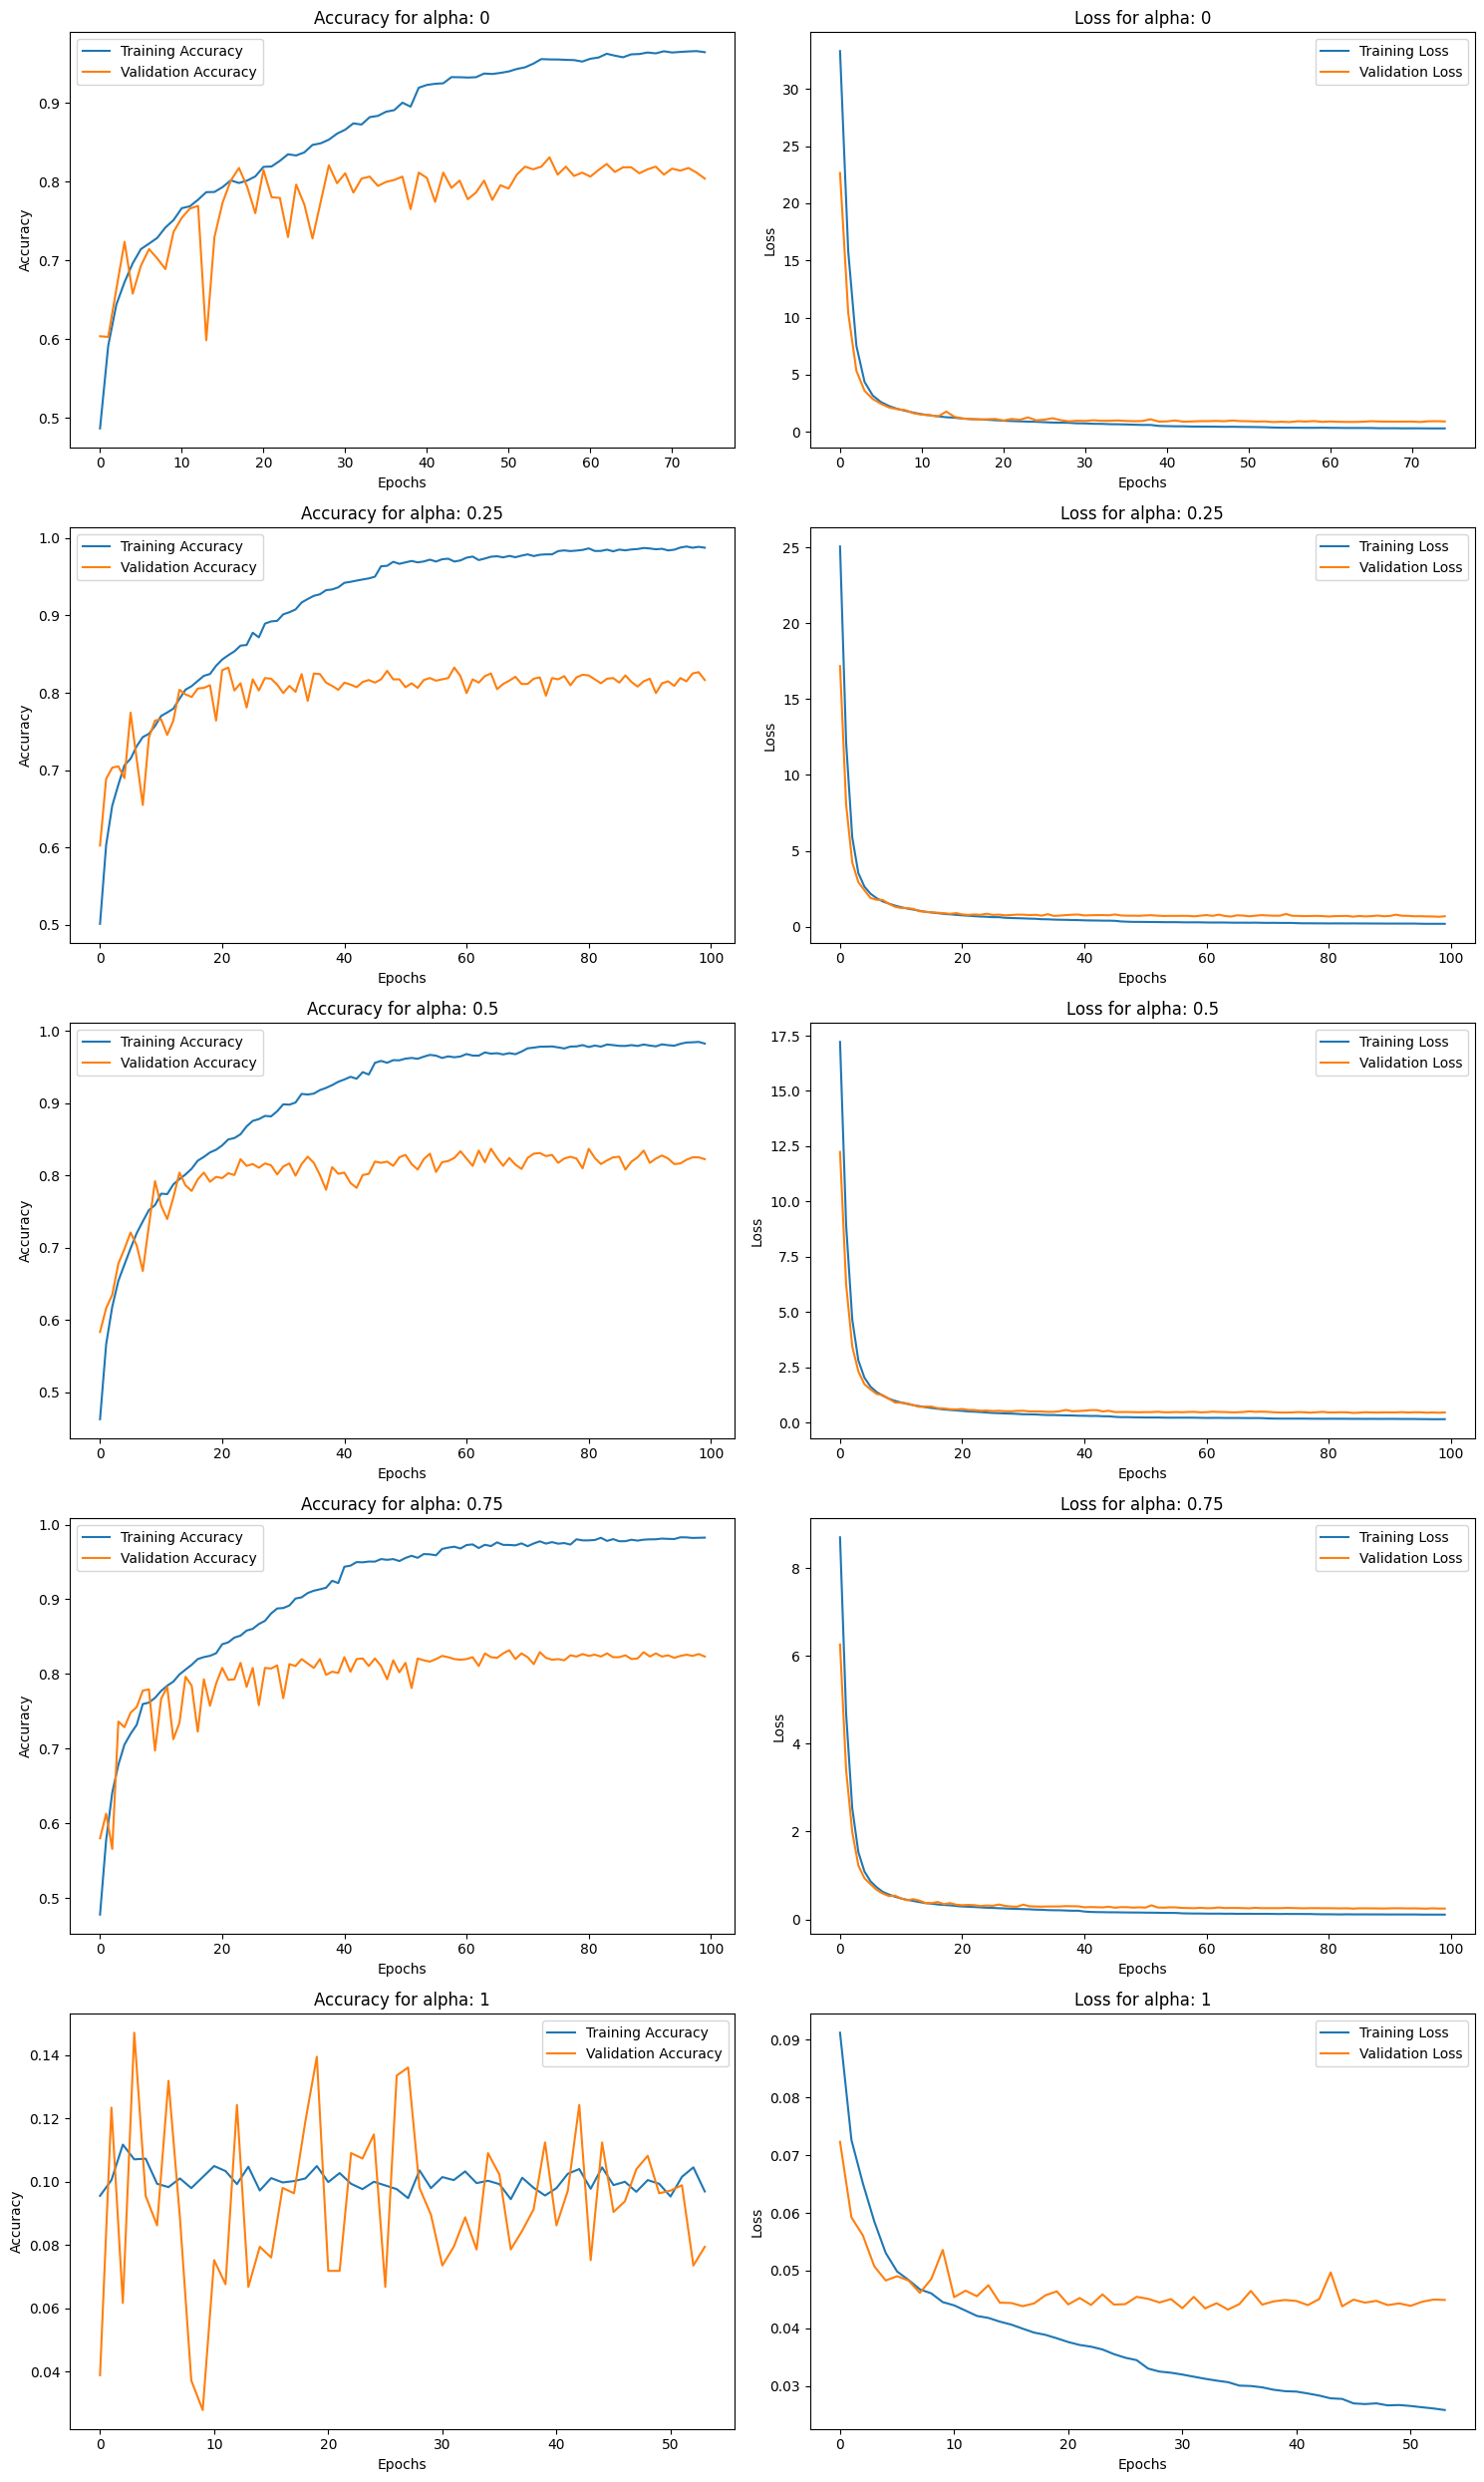

In [18]:
# Plotting
def plot_history(history_dict):
    num_combinations = len(history_dict)
    fig, axs = plt.subplots(num_combinations, 2, figsize=(15, 5 * num_combinations))
    
    if num_combinations == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, (params, history) in enumerate(history_dict.items()):
        # param_str = f"alpha: {params[0]}, l1 = {params[1]}, l2 = {params[2]}"
        if only_alpha:
            param_str = f"alpha: {params[0]}"
        else:
            param_str = f"alpha: {params[0]}, l2 = {params[1]}"
        
        # Plot accuracy
        axs[i, 0].plot(history['accuracy'], label='Training Accuracy')
        axs[i, 0].plot(history['val_accuracy'], label='Validation Accuracy')
        axs[i, 0].set_title(f'Accuracy for {param_str}')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel('Accuracy')
        axs[i, 0].legend()
        
        # Plot loss
        axs[i, 1].plot(history['loss'], label='Training Loss')
        axs[i, 1].plot(history['val_loss'], label='Validation Loss')
        axs[i, 1].set_title(f'Loss for {param_str}')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history_dict)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


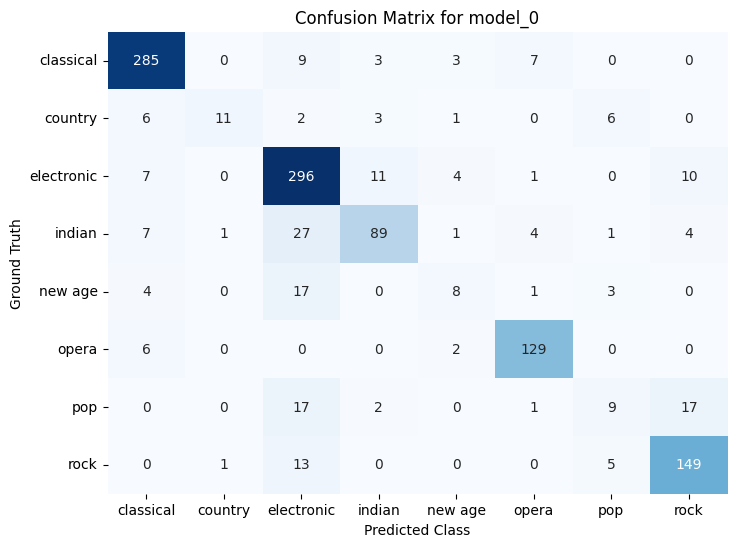

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


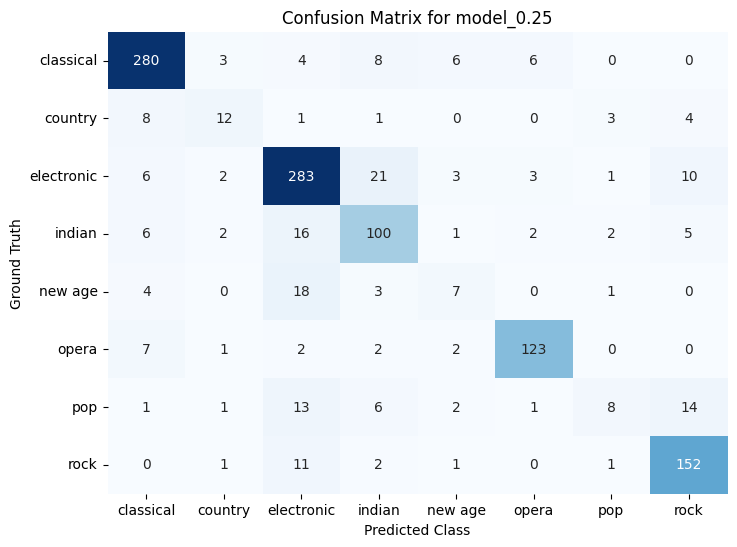

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


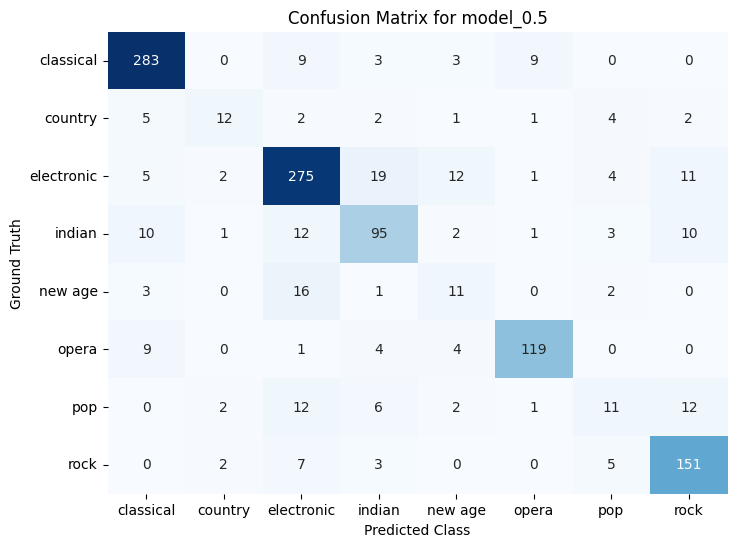

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


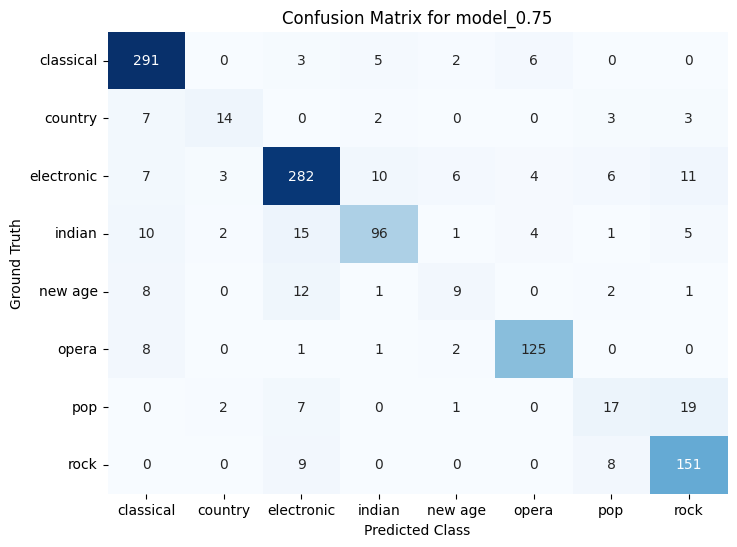

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


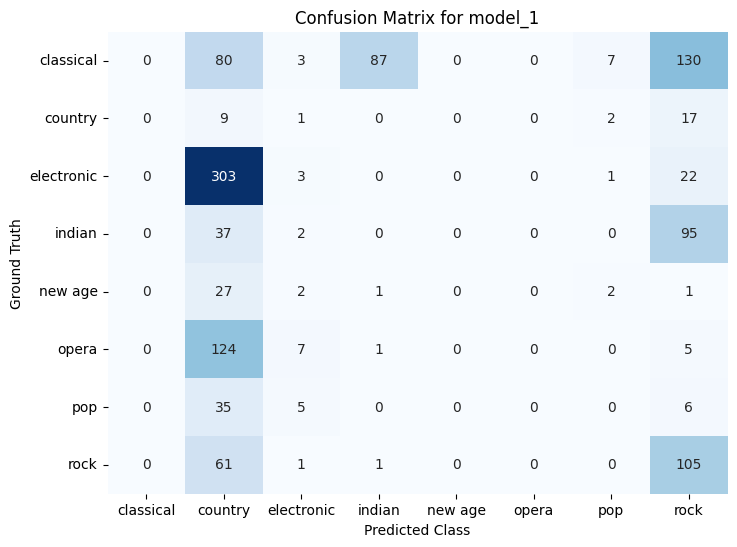

In [19]:
for k, v in models.items():
    
    best_model = v
    
    # Get predictions from the best model
    predictions = best_model.predict((X_test_spec, X_test_embed_tensor))
    predicted_class_probabilities = predictions[0]  # This gives you the (1183, 8) array
    predicted_labels = np.argmax(predicted_class_probabilities, axis=1)
    ground_truth = np.argmax(y_test, axis=1)  # Converting one-hot encoded ground truth to class labels

    # Reshape predicted_labels and ground_truth to be 1D arrays
    predicted_labels = np.reshape(predicted_labels, (-1,))
    ground_truth = np.reshape(ground_truth, (-1,))

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(ground_truth, predicted_labels, average='macro')
    test_recall = recall_score(ground_truth, predicted_labels, average='macro')
    test_f1_score = f1_score(ground_truth, predicted_labels, average='macro')

    results_dict[(float(str.split(k,'_')[1]),)]["test_precision"] = test_precision
    results_dict[(float(str.split(k,'_')[1]),)]["test_recall"] = test_recall
    results_dict[(float(str.split(k,'_')[1]),)]["test_f1_score"] = test_f1_score
    
    # Define class labels
    class_labels = ['classical', 'country', 'electronic', 'indian',
                    'new age', 'opera', 'pop', 'rock']

    # Convert numerical labels to class labels
    predicted_labels = [class_labels[i] for i in predicted_labels]
    ground_truth = [class_labels[i] for i in ground_truth]

    # Create confusion matrix
    conf_matrix = confusion_matrix(ground_truth, predicted_labels, labels=class_labels)

    # Convert confusion matrix to DataFrame for better visualization
    conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Ground Truth')
    plt.title(f'Confusion Matrix for {k}')
    plt.show()


In [20]:
pd.DataFrame(results_dict)

,0.00,0.25,0.50,0.75,1.00
train_accuracy,0.989535,0.998943,0.999049,0.999894,0.099366
train_loss,0.277620,0.166771,0.142667,0.100434,0.026076
val_accuracy,0.830938,0.826712,0.825021,0.825866,0.109045
val_loss,0.853034,0.655187,0.429556,0.244684,0.043248
test_accuracy,0.825021,0.815723,0.808960,0.832629,0.098901
test_loss,0.816431,0.652653,0.458353,0.240776,0.043898
test_precision,0.734728,0.688291,0.684321,0.727474,0.051738
test_recall,0.642264,0.640113,0.652541,0.682214,0.118058
test_f1_score,0.669017,0.651443,0.663234,0.699100,0.053130


In [21]:
with open('/home/mendu/Thesis/data/saved_models/grid_search_alpha_128/result_dict.pkl', 'wb') as fp:
    pickle.dump(results_dict, fp)
    
with open('/home/mendu/Thesis/data/saved_models/grid_search_alpha_128/history_dict.pkl', 'wb') as fp:
    pickle.dump(history_dict, fp)

In [22]:
# Assuming models and other variables are already defined
misclassified_dict = {}

# Iterate over the models and their corresponding parameter values
for model_name, model in models.items():
    # Get model predictions
    y_test_pred = model.predict((X_test_spec, X_test_embed_tensor))
    
    # Check if y_val_pred is a tuple and select the appropriate output
    if isinstance(y_test_pred, tuple):
        y_test_pred = y_test_pred[0]  # Assuming the first element is the logits or probabilities
    
    # Ensure y_val_pred is a 2D array
    if y_test_pred.ndim == 2:
        y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    else:
        raise ValueError(f"Unexpected output shape {y_test_pred.shape} for model {model_name}")

    # Get the true labels
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Find misclassified samples
    misclassified_indices = np.where(y_test_pred_labels != y_test_true_labels)[0]
    wrong_labels = y_test_pred_labels[misclassified_indices]
    correct_labels = y_test_true_labels[misclassified_indices]

    # Create a dataframe
    df_misclassified = pd.DataFrame({
        'Index': misclassified_indices,
        'Wrong Label': wrong_labels,
        'Correct Label': correct_labels
    })

    # Store the dataframe in the dictionary
    misclassified_dict[model_name] = df_misclassified


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


In [23]:
model_0 = misclassified_dict['model_0']
model_25= misclassified_dict['model_0.25']
model_5 = misclassified_dict['model_0.5']
model_75 = misclassified_dict['model_0.75']

In [24]:
# Rename the Wrong Label columns for clarity
model_0 = model_0.rename(columns={'Wrong Label': 'Wrong Label_0'})
model_25 = model_25.rename(columns={'Wrong Label': 'Wrong Label_25'})
model_5 = model_5.rename(columns={'Wrong Label': 'Wrong Label_5'})
model_75 = model_75.rename(columns={'Wrong Label': 'Wrong Label_75'})
# model_1 = model_1.rename(columns={'Wrong Label': 'Wrong Label_1'})

# Merge the dataframes
merged_df = pd.merge(model_0, model_25, on=['Index', 'Correct Label'], how='outer')
merged_df = pd.merge(merged_df, model_5, on=['Index', 'Correct Label'], how='outer')
merged_df = pd.merge(merged_df, model_75, on=['Index', 'Correct Label'], how='outer')
# merged_df = pd.merge(merged_df, model_1, on=['Index', 'Correct Label'], how='outer')

In [25]:
# Genre mapping
genre_map = {
    0: 'classical',
    1: 'country',
    2: 'electronic',
    3: 'indian',
    4: 'new age',
    5: 'opera',
    6: 'pop',
    7: 'rock'
}

# Replace numeric labels with genre names
columns_to_replace = ['Correct Label', 'Wrong Label_0', 'Wrong Label_25', 'Wrong Label_5', 'Wrong Label_75']
for col in columns_to_replace:
    merged_df[col] = merged_df[col].map(genre_map)

# Display the merged dataframe
merged_df

,Index,Wrong Label_0,Correct Label,Wrong Label_25,Wrong Label_5,Wrong Label_75
0,2,classical,country,classical,classical,classical
1,3,NaN,indian,electronic,NaN,NaN
2,9,electronic,new age,electronic,electronic,electronic
3,10,opera,classical,opera,opera,NaN
4,12,electronic,new age,classical,NaN,NaN
...,...,...,...,...,...,...
316,1169,NaN,rock,NaN,NaN,pop
317,1173,electronic,indian,electronic,electronic,electronic
318,1176,electronic,rock,electronic,electronic,electronic
319,1180,pop,rock,electronic,pop,NaN


In [26]:
merged_df.columns

Index(['Index', 'Wrong Label_0', 'Correct Label', 'Wrong Label_25',
       'Wrong Label_5', 'Wrong Label_75'],
      dtype='object')

In [27]:
merged_df = merged_df[['Index', 'Correct Label', 'Wrong Label_0', 'Wrong Label_25',
       'Wrong Label_5', 'Wrong Label_75']]

In [28]:
merged_df = merged_df.dropna(subset=['Wrong Label_0',  'Wrong Label_25', 'Wrong Label_5', 'Wrong Label_75'])

In [40]:
merged_df

,Index,Correct Label,Wrong Label_0,Wrong Label_25,Wrong Label_5,Wrong Label_75,Highest Wrong Label
0,2,country,classical,classical,classical,classical,4
2,9,new age,electronic,electronic,electronic,electronic,4
5,15,new age,electronic,electronic,electronic,electronic,4
6,17,pop,rock,rock,indian,rock,3
7,21,opera,classical,classical,classical,classical,4
...,...,...,...,...,...,...,...
308,1134,indian,classical,classical,classical,classical,4
311,1142,rock,electronic,electronic,indian,electronic,3
313,1145,indian,electronic,country,rock,rock,2
317,1173,indian,electronic,electronic,electronic,electronic,4


In [30]:
# merged_df = merged_df[['Index', 'Correct Label', 'Wrong Label_0',  'Wrong Label_4', 'Wrong Label_5', 'Wrong Label_6']]

# Initialize a new column with zeros
merged_df['Highest Wrong Label'] = 0

# Iterate over each row to count the number of identical wrong labels
for i, row in merged_df.iterrows():
    wrong_labels = row[['Wrong Label_0',  'Wrong Label_25', 'Wrong Label_5', 'Wrong Label_75']]
    # Drop NaN values before checking uniqueness
    unique_labels = wrong_labels.dropna().value_counts().index.tolist()[0] 
    unique_labels_count = wrong_labels.dropna().value_counts().iloc[0]
    merged_df.at[i, 'Highest Wrong Label'] = unique_labels_count

In [31]:
merged_df['Highest Wrong Label'].value_counts()


Highest Wrong Label
4    64
3    29
2    20
Name: count, dtype: int64

In [32]:
merged_df.to_csv('/home/mendu/Thesis/data/saved_models/grid_search_alpha_128/error_analysis_df.csv')

In [33]:
# import pickle

# with open('/home/mendu/Thesis/data/magnatagatune/history_dict_gridsearch4.pkl', 'wb') as f:
#     pickle.dump(history_dict, f)

In [34]:
# early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# history = model.fit(
#     (X_train_spec, X_train_embed_tensor),
#     y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=((X_val_spec, X_val_embed_tensor), y_val),
#     callbacks = [early_stopper]
# )

In [35]:
# # First, let's gather the maximum epoch number reached among all histories
# max_epoch = max([len(history['accuracy']) for history in history_dict.values()])

# # Now, for plotting purposes, let's create four separate figures
# fig_acc, ax_acc = plt.subplots()
# fig_val_acc, ax_val_acc = plt.subplots()
# fig_loss, ax_loss = plt.subplots()
# fig_val_loss, ax_val_loss = plt.subplots()

# # Now we loop through each combination's history and plot it appropriately
# for parameter_combination, history in history_dict.items():
#     num_epochs = len(history['accuracy'])
#     epochs = range(1, num_epochs + 1)

#     # Parameters string for legend label
#     params_label = f'l1_reg={parameter_combination[0]}_l2_reg={parameter_combination[1]}'

#     # Training accuracy for this combination
#     ax_acc.plot(epochs, history['accuracy'], label=params_label)

#     # Validation accuracy for this combination
#     ax_val_acc.plot(epochs, history['val_accuracy'], label=params_label)
    
#     # Training loss for this combination
#     ax_loss.plot(epochs, history['loss'], label=params_label)
    
#     # Validation loss for this combination
#     ax_val_loss.plot(epochs, history['val_loss'], label=params_label)

# # After plotting all combinations on separate figures, let's show the plots with legends
# ax_acc.set_title('Training Accuracy for all combinations')
# ax_acc.set_xlabel('Epoch')
# ax_acc.set_ylabel('Accuracy')
# ax_acc.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_val_acc.set_title('Validation Accuracy for all combinations')
# ax_val_acc.set_xlabel('Epoch')
# ax_val_acc.set_ylabel('Accuracy')
# ax_val_acc.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_loss.set_title('Training Loss for all combinations')
# ax_loss.set_xlabel('Epoch')
# ax_loss.set_ylabel('Loss')
# ax_loss.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_val_loss.set_title('Validation Loss for all combinations')
# ax_val_loss.set_xlabel('Epoch')
# ax_val_loss.set_ylabel('Loss')
# ax_val_loss.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig_acc.show()
# fig_val_acc.show()
# fig_loss.show()
# fig_val_loss.show()

In [36]:
# # Plot a graph for training and validation loss
# plt.figure(figsize=(10, 5)) # Optionally specify the figure size
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot a graph for training and validation accuracy
# plt.figure(figsize=(10, 5)) # Optionally specify the figure size
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoche')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [37]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Get predictions
# predictions = model.predict((X_val_spec, X_val_embed_tensor))
# predicted_labels = np.argmax(predictions[0], axis=1)  # Converting probabilities to class labels
# ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# # Reshape predicted_labels and ground_truth to be 1D arrays
# predicted_labels = np.reshape(predicted_labels, (-1,))
# ground_truth = np.reshape(ground_truth, (-1,))

# # Define class labels
# class_labels = ['classical', 'country', 'electronic', 'indian',
#                 'new age', 'opera', 'pop', 'rock']

# predicted_labels = [class_labels[i] for i in predicted_labels]
# ground_truth = [class_labels[i] for i in ground_truth]

# # Create a table with prediction and ground truth
# comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})
# # Get unique class labels
# unique_labels = sorted(comparison_table['Ground Truth'].unique())

# # Create confusion matrix
# conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# # Convert confusion matrix to DataFrame for better visualization
# conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
# plt.xlabel('Predicted Class')
# plt.ylabel('Ground Truth')
# plt.title('Confusion Matrix')
# plt.show()


In [38]:
# # First, let's gather the maximum epoch number reached among all histories
# max_epoch = max([len(history['accuracy']) for history in history_dict.values()])

# # Now, for plotting purposes, let's create four separate figures
# fig_acc, ax_acc = plt.subplots()
# fig_val_acc, ax_val_acc = plt.subplots()
# fig_loss, ax_loss = plt.subplots()
# fig_val_loss, ax_val_loss = plt.subplots()

# # Now we loop through each combination's history and plot it appropriately
# for parameter_combination, history in history_dict.items():
#     num_epochs = len(history['accuracy'])
#     epochs = range(1, num_epochs + 1)

#     # Parameters string for legend label
#     params_label = f'l1_reg={parameter_combination[0]}_l2_reg={parameter_combination[1]}'

#     # Training accuracy for this combination
#     ax_acc.plot(epochs, history['accuracy'], label=params_label)

#     # Validation accuracy for this combination
#     ax_val_acc.plot(epochs, history['val_accuracy'], label=params_label)
    
#     # Training loss for this combination
#     ax_loss.plot(epochs, history['loss'], label=params_label)
    
#     # Validation loss for this combination
#     ax_val_loss.plot(epochs, history['val_loss'], label=params_label)

# # After plotting all combinations on separate figures, let's show the plots with legends
# ax_acc.set_title('Training Accuracy for all combinations')
# ax_acc.set_xlabel('Epoch')
# ax_acc.set_ylabel('Accuracy')
# ax_acc.legend()

# ax_val_acc.set_title('Validation Accuracy for all combinations')
# ax_val_acc.set_xlabel('Epoch')
# ax_val_acc.set_ylabel('Accuracy')
# ax_val_acc.legend()

# ax_loss.set_title('Training Loss for all combinations')
# ax_loss.set_xlabel('Epoch')
# ax_loss.set_ylabel('Loss')
# ax_loss.legend()

# ax_val_loss.set_title('Validation Loss for all combinations')
# ax_val_loss.set_xlabel('Epoch')
# ax_val_loss.set_ylabel('Loss')
# ax_val_loss.legend()

# fig_acc.show()
# fig_val_acc.show()
# fig_loss.show()
# fig_val_loss.show()

In [39]:
'''For inidivially printing the train_acc, val_acc, train_loss, val_loss'''
# # Define number of subplots needed
# num_combinations = len(history_dict)
# rows = cols = int(num_combinations ** 0.5)
# cols = rows if rows * rows == num_combinations else rows + 1

# # If the square root of combinations does not give an integer grid, slightly increase the number of columns
# if rows * cols < num_combinations:
#     cols += 1

# # Create subplots for each metric
# fig_size = (20,7)
# fig_acc, axes_acc = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
# fig_val_acc, axes_val_acc = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
# fig_loss, axes_loss = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
# fig_val_loss, axes_val_loss = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)

# # Flatten the axes array for easy iteration
# axes_acc_flat = axes_acc.flatten()
# axes_val_acc_flat = axes_val_acc.flatten()
# axes_loss_flat = axes_loss.flatten()
# axes_val_loss_flat = axes_val_loss.flatten()

# # Loop through each combination's history and plot it in a dedicated subplot
# for idx, (parameter_combination, history) in enumerate(history_dict.items()):
#     num_epochs = len(history['accuracy'])
#     epochs = range(1, num_epochs + 1)

#     # Parameters string for legend label
#     # params_label = f"alpha={parameter_combination[0]}, l1 = {parameter_combination[1]}, l2 = {parameter_combination[2]}"
#     params_label = f"alpha={parameter_combination[0]}"
#     # params_label = f"alpha={parameter_combination[0]}, l2 = {parameter_combination[1]}"
    
#     # Plot Training accuracy for this combination
#     axes_acc_flat[idx].plot(epochs, history['accuracy'], label=params_label)
#     axes_acc_flat[idx].set_title(params_label)
#     axes_acc_flat[idx].set_xlabel('Epoch')
#     axes_acc_flat[idx].set_ylabel('Accuracy')

#     # Plot Validation accuracy for this combination
#     axes_val_acc_flat[idx].plot(epochs, history['val_accuracy'], label=params_label)
#     axes_val_acc_flat[idx].set_title(params_label)
#     axes_val_acc_flat[idx].set_xlabel('Epoch')
#     axes_val_acc_flat[idx].set_ylabel('Val Accuracy')

#     # Plot Training loss for this combination
#     axes_loss_flat[idx].plot(epochs, history['loss'], label=params_label)
#     axes_loss_flat[idx].set_title(params_label)
#     axes_loss_flat[idx].set_xlabel('Epoch')
#     axes_loss_flat[idx].set_ylabel('Loss')

#     # Plot Validation loss for this combination
#     axes_val_loss_flat[idx].plot(epochs, history['val_loss'], label=params_label)
#     axes_val_loss_flat[idx].set_title(params_label)
#     axes_val_loss_flat[idx].set_xlabel('Epoch')
#     axes_val_loss_flat[idx].set_ylabel('Val Loss')

# # After adding all the plots to the subplots, adjust the layout and add the legend outside the last axis in each figure
# for axes, fig in [(axes_acc_flat, fig_acc), 
#                   (axes_val_acc_flat, fig_val_acc), 
#                   (axes_loss_flat, fig_loss), 
#                   (axes_val_loss_flat, fig_val_loss)]:
#     # Put a legend to the right of the last subplot
#     axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

#     # Hide any unused axes if the number of combinations isn't a perfect square
#     for ax in axes[num_combinations:]:
#         ax.set_visible(False)

#     fig.tight_layout()
#     fig.subplots_adjust(right=0.85)  # Adjust subplot params so the legend outside fits
#     fig.show()

'For inidivially printing the train_acc, val_acc, train_loss, val_loss'